In [1]:
import torch,imageio,sys,time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

sys.path.append('..')
from models.FactorFields import FactorFields 

from utils import SimpleSampler
from dataLoader import dataset_dict
from torch.utils.data import DataLoader
imageio.plugins.freeimage.download()

device = 'cuda'
torch.cuda.set_device(0)

%load_ext autoreload
%autoreload 2

In [2]:
def PSNR(a,b):
    if type(a).__module__ == np.__name__:
        mse = np.mean((a-b)**2)
    else:
        mse = torch.mean((a-b)**2).item()
    psnr = -10.0 * np.log(mse) / np.log(10.0)
    return psnr

@torch.no_grad()
def eval_img(reso, chunk=10240):
    y = torch.arange(0, reso[0])
    x = torch.arange(0, reso[1])
    yy, xx = torch.meshgrid((y, x), indexing='ij')
    res = []
    
    coordiantes = torch.stack((xx,yy),dim=-1).reshape(-1,2) + 0.5 #/(torch.FloatTensor(reso[::-1])-1)*2-1
    coordiantes = torch.split(coordiantes,chunk,dim=0)
    for coordiante in tqdm(coordiantes):

        feats,_ = model.get_coding(coordiante.to(model.device))
        y_recon = model.linear_mat(feats)
        
        res.append(y_recon.cpu())
    return torch.cat(res).reshape(reso[0],reso[1],-1)

def srgb_to_linear(img):
	limit = 0.04045
	return np.where(img > limit, np.power((img + 0.055) / 1.055, 2.4), img / 12.92)

# Data loader
### please install the av package with "pip install av" if raise a error "pyav:  pip install imageio[pyav]"

In [3]:
base_conf = OmegaConf.load('../configs/defaults.yaml')
second_conf = OmegaConf.load('../configs/image.yaml')
cfg = OmegaConf.merge(base_conf, second_conf)

dataset = dataset_dict[cfg.dataset.dataset_name]
tolinear = False if cfg.dataset.datadir.endswith('exr') else True
train_dataset = dataset(cfg.dataset, cfg.training.batch_size, split='train', tolinear=tolinear)
train_loader = DataLoader(train_dataset,
              num_workers=8,
              persistent_workers=True,
              batch_size=None,
              pin_memory=True)

cfg.model.out_dim = train_dataset.img.shape[-1]
batch_size = cfg.training.batch_size
n_iter = cfg.training.n_iters

H,W = train_dataset.HW
cfg.dataset.aabb = train_dataset.scene_bbox

=====> total parameters:  1429376
FactorFields(
  (coeffs): ParameterList(  (0): Parameter containing: [torch.cuda.FloatTensor of size 1x144x63x63 (GPU 0)])
  (basises): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 1x32x32x32 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 1x32x51x51 (GPU 0)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 1x32x70x70 (GPU 0)]
      (3): Parameter containing: [torch.cuda.FloatTensor of size 1x16x89x89 (GPU 0)]
      (4): Parameter containing: [torch.cuda.FloatTensor of size 1x16x108x108 (GPU 0)]
      (5): Parameter containing: [torch.cuda.FloatTensor of size 1x16x128x128 (GPU 0)]
  )
  (linear_mat): MLPMixer(
    (backbone): ModuleList(
      (0): Linear(in_features=144, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=4, bias=False)
    )
  )
)
total parameters:  1429376


Iteration 09999: loss_dist = 0.00000031 psnr = 65.022: 100%|██████████| 10000/10000 [01:32<00:00, 108.54it/s]
100%|████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 1117.18it/s]


65.70337395134173 92.13329100608826


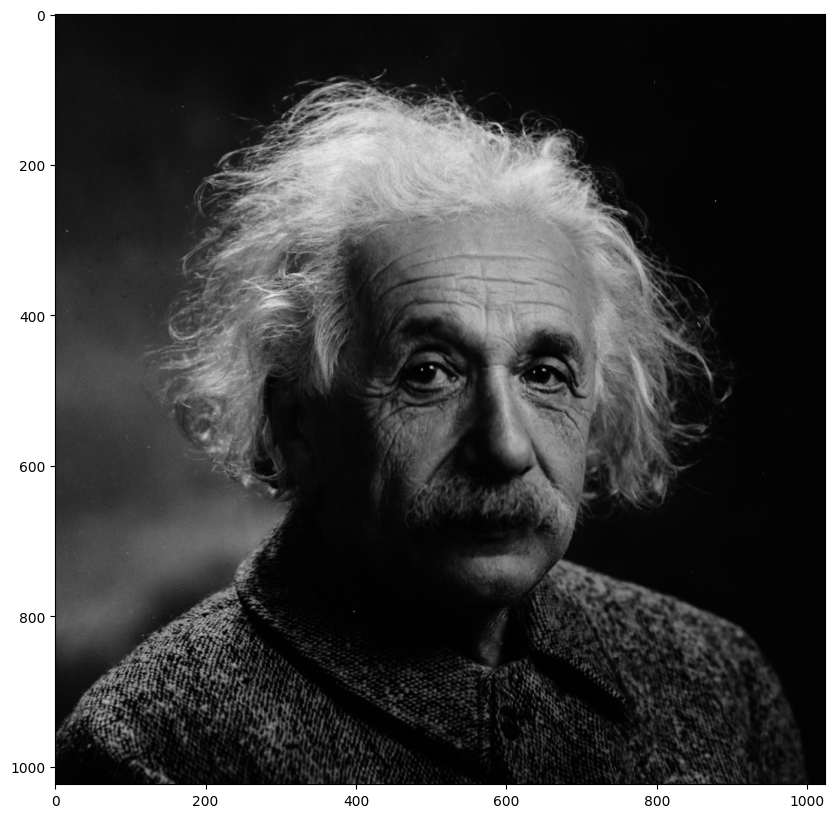

In [4]:
model = FactorFields(cfg, device)
print(model)
print('total parameters: ',model.n_parameters())

grad_vars = model.get_optparam_groups(lr_small=cfg.training.lr_small,lr_large=cfg.training.lr_large)
optimizer = torch.optim.Adam(grad_vars, betas=(0.9, 0.99))#



loss_scale = 1.0
lr_factor = 0.1 ** (1 / n_iter)
pbar = tqdm(range(n_iter))
start = time.time()
for (iteration, sample) in zip(pbar,train_loader):
    loss_scale *= lr_factor

    coordiantes, pixel_rgb = sample['xy'], sample['rgb']
    feats,coeff = model.get_coding(coordiantes.to(device))
    
    y_recon = model.linear_mat(feats)
    
    loss = torch.mean((y_recon.squeeze()-pixel_rgb.to(device))**2) 
    
    
    psnr = -10.0 * np.log(loss.item()) / np.log(10.0)
    pbar.set_description(
                f'Iteration {iteration:05d}:'
                + f' loss_dist = {loss.item():.8f}'
                + f' psnr = {psnr:.3f}'
            )
    
    loss = loss * loss_scale
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
iteration_time = time.time()-start  
    
H,W = train_dataset.HW
img = eval_img(train_dataset.HW).clamp(0,1.)
print(PSNR(img,train_dataset.image.view(img.shape)),iteration_time)
plt.figure(figsize=(10, 10))
plt.imshow(img)